In [38]:
import os
# This is where the an4/ directory will be placed.
# Change this if you don't want the data to be extracted in the current directory.
data_dir = 'resources/sample_data'

if not os.path.exists(data_dir):
  os.makedirs(data_dir)

In [39]:
import glob
import os
import subprocess
import tarfile
import wget

# Download the dataset. This will take a few moments...
print("******")
if not os.path.exists(data_dir + '/an4_sphere.tar.gz'):
    an4_url = 'https://dldata-public.s3.us-east-2.amazonaws.com/an4_sphere.tar.gz'
    an4_path = wget.download(an4_url, data_dir)
    print(f"Dataset downloaded at: {an4_path}")
else:
    print("Tarfile already exists.")
    an4_path = data_dir + '/an4_sphere.tar.gz'

if not os.path.exists(data_dir + '/an4/'):
    # Untar and convert .sph to .wav (using sox)
    tar = tarfile.open(an4_path)
    tar.extractall(path=data_dir)

    print("Converting .sph to .wav...")
    sph_list = glob.glob(data_dir + '/an4/**/*.sph', recursive=True)
    for sph_path in sph_list:
        wav_path = sph_path[:-4] + '.wav'
        cmd = ["sox", sph_path, wav_path]
        subprocess.run(cmd)
print("Finished conversion.\n******")

******
Tarfile already exists.
Finished conversion.
******


In [40]:
import librosa
import IPython.display as ipd

# Load and listen to the audio file
example_file = data_dir + '/an4/wav/an4_clstk/mgah/cen2-mgah-b.wav'
audio, sample_rate = librosa.load(example_file)

ipd.Audio(example_file, rate=sample_rate)

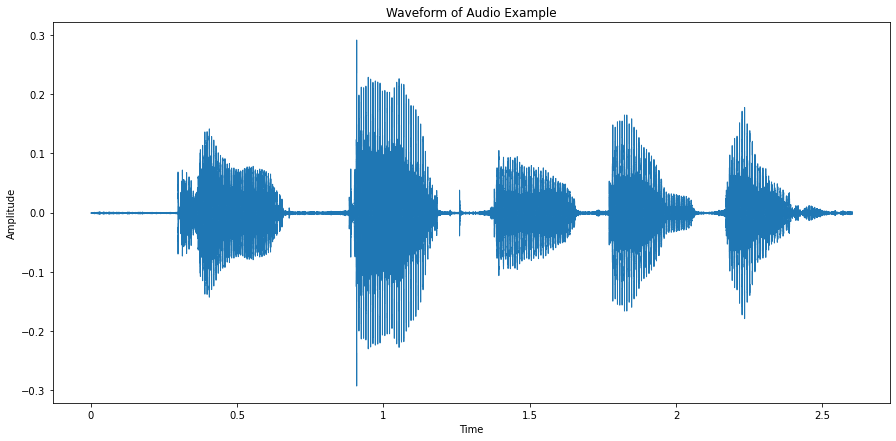

In [41]:
%matplotlib inline
import librosa.display
import matplotlib.pyplot as plt

# Plot our example audio file's waveform
plt.rcParams['figure.figsize'] = (15,7)
plt.title('Waveform of Audio Example')
plt.ylabel('Amplitude')

_ = librosa.display.waveshow(audio)

In [73]:
import json

# Function to build a manifest
def build_manifest(transcripts_path, manifest_path, wav_path):
    with open(transcripts_path, 'r') as fin:
        with open(manifest_path, 'w') as fout:
            for line in fin:
                # Lines look like this:
                # <s> transcript </s> (fileID)
                transcript = line[: line.find('(')-1].lower()
                transcript = transcript.replace('<s>', '').replace('</s>', '')
                transcript = transcript.strip()

                file_id = line[line.find('(')+1 : -2]  # e.g. "cen4-fash-b"
                audio_path = os.path.join(
                    data_dir, wav_path,
                    file_id[file_id.find('-')+1 : file_id.rfind('-')],
                    file_id + '.wav')

                duration = librosa.core.get_duration(filename=audio_path)

                # Write the metadata to the manifest
                metadata = {
                    "audio_filepath": audio_path,
                    "duration": duration,
                    "text": transcript
                }
                json.dump(metadata, fout)
                fout.write('\n')
                
# Building Manifests
print("******")
train_transcripts = data_dir + '/an4/etc/an4_train.transcription'
train_manifest = data_dir + '/an4/train_manifest.json'
if not os.path.isfile(train_manifest):
    build_manifest(train_transcripts, train_manifest, 'an4/wav/an4_clstk')
    print("Training manifest created.")

test_transcripts = data_dir + '/an4/etc/an4_test.transcription'
test_manifest = data_dir + '/an4/test_manifest.json'
if not os.path.isfile(test_manifest):
    build_manifest(test_transcripts, test_manifest, 'an4/wav/an4test_clstk')
    print("Test manifest created.")
print("***Done***")

******
***Done***


In [83]:
# length of the train manifest

with open(train_manifest) as f:
    lines = f.readlines()


# randomly pick 20% of the data for validation
    
import random
random.shuffle(lines)

val_lines = lines[:int(len(lines)*0.2)]
train_lines = lines[int(len(lines)*0.2):]

with open(data_dir + '/an4/train_manifest.json', 'w') as fout:
    for line in train_lines:
        fout.write(line)

with open(data_dir + '/an4/val_manifest.json', 'w') as fout:
    for line in val_lines:
        fout.write(line)

In [44]:
# read training manifest file and convert it to a dataframe

import pandas as pd
train_df = pd.read_json(train_manifest, lines=True)



In [45]:
train_df.head()

,audio_filepath,duration,text
0,resources/sample_data/an4/wav/an4_clstk/fash/a...,1.0,yes
1,resources/sample_data/an4/wav/an4_clstk/fash/a...,0.7,go
2,resources/sample_data/an4/wav/an4_clstk/fash/a...,0.9,yes
3,resources/sample_data/an4/wav/an4_clstk/fash/a...,2.6,u m n y h six
4,resources/sample_data/an4/wav/an4_clstk/fash/c...,3.5,h i n i c h


In [46]:
sum(train_df['duration']) / 60, "minutes"

(42.43833333333338, 'minutes')

In [242]:
# --- Config Information ---#
try:
    from ruamel.yaml import YAML
except ModuleNotFoundError:
    from ruamel_yaml import YAML
config_path = './configs/fast-conformer_ctc_bpe.yaml'

if not os.path.exists(config_path):
    # Grab the config we'll use in this example
    BRANCH = 'r1.21.0'
    !mkdir configs
    !wget -P configs/ https://raw.githubusercontent.com/NVIDIA/NeMo/$BRANCH/examples/asr/conf/fastconformer/fast-conformer_ctc_bpe.yaml

yaml = YAML(typ='safe')
with open(config_path) as f:
    params = yaml.load(f)
print(params)

{'name': 'FastConformer-CTC-BPE', 'model': {'sample_rate': 16000, 'log_prediction': True, 'ctc_reduction': 'mean_volume', 'skip_nan_grad': False, 'train_ds': {'manifest_filepath': '???', 'sample_rate': 16000, 'batch_size': 16, 'shuffle': True, 'num_workers': 8, 'pin_memory': True, 'max_duration': 16.7, 'min_duration': 0.1, 'is_tarred': False, 'tarred_audio_filepaths': None, 'shuffle_n': 2048, 'bucketing_strategy': 'fully_randomized', 'bucketing_batch_size': None}, 'validation_ds': {'manifest_filepath': '???', 'sample_rate': 16000, 'batch_size': 16, 'shuffle': False, 'use_start_end_token': False, 'num_workers': 8, 'pin_memory': True}, 'test_ds': {'manifest_filepath': None, 'sample_rate': 16000, 'batch_size': 16, 'shuffle': False, 'use_start_end_token': False, 'num_workers': 8, 'pin_memory': True}, 'tokenizer': {'dir': '???', 'type': 'bpe'}, 'preprocessor': {'_target_': 'nemo.collections.asr.modules.AudioToMelSpectrogramPreprocessor', 'sample_rate': 16000, 'normalize': 'per_feature', 'wi

In [250]:
!${model.sample_rate} = 16000

/bin/bash: line 1: ${model.sample_rate}: bad substitution


In [251]:
!${model.preprocessor.features} = 80

/bin/bash: line 1: ${model.preprocessor.features}: bad substitution


In [252]:
params["model"]["train_ds"]["sample_rate"] = 16000
params["model"]["validation_ds"]["sample_rate"] = 16000
params["model"]["test_ds"]["sample_rate"] = 16000

In [253]:
params["model"]["encoder"]["feat_in"] = 80

In [240]:
import nemo
import nemo.collections.asr as nemo_asr

In [241]:
import pytorch_lightning as pl
trainer = pl.Trainer(devices=1, accelerator='gpu', max_epochs=50)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [55]:
!git clone https://github.com/NVIDIA/NeMo

fatal: destination path 'NeMo' already exists and is not an empty directory.


In [197]:
tokenizer = "NeMo/scripts/tokenizers/process_asr_text_tokenizer.py"

In [198]:
train_manifest

'resources/sample_data/an4/train_manifest.json'

In [243]:
! python3 NeMo/scripts/tokenizers/process_asr_text_tokenizer.py --manifest=resources/sample_data/an4/train_manifest.json,resources/sample_data/an4/test_manifest.json,resources/sample_data/an4/val_manifest.json \
    --data_root=resources/sample_data/an4/wav/an4_clstk \
    --vocab_size=128 \
    --tokenizer="spe" \
    --log

/home/ubuntu/.local/lib/python3.10/site-packages/pkg_resources/__init__.py:123: PkgResourcesDeprecationWarning: 1.1build1 is an invalid version and will not be supported in a future release
  warnings.warn(
/home/ubuntu/.local/lib/python3.10/site-packages/pkg_resources/__init__.py:123: PkgResourcesDeprecationWarning: 0.1.43ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(
INFO:root:Corpus already exists at path : resources/sample_data/an4/wav/an4_clstk/text_corpus/document.txt
[NeMo I 2024-01-03 14:27:03 sentencepiece_tokenizer:316] Processing resources/sample_data/an4/wav/an4_clstk/text_corpus/document.txt and store at resources/sample_data/an4/wav/an4_clstk/tokenizer_spe_bpe_v128
sentencepiece_trainer.cc(177) LOG(INFO) Running command: --input=resources/sample_data/an4/wav/an4_clstk/text_corpus/document.txt --model_prefix=resources/sample_data/an4/wav/an4_clstk/tokenizer_spe_bpe_v128/tokenizer --vocab_size=128 --shuffle_input_sentence=true -

In [244]:
params["model"]["tokenizer"]["dir"] = "resources/sample_data/an4/wav/an4_clstk/tokenizer_spe_bpe_v128"

In [245]:
params["model"]["tokenizer"]["dir"]

'resources/sample_data/an4/wav/an4_clstk/tokenizer_spe_bpe_v128'

In [246]:
params["model"]["test_ds"]

{'manifest_filepath': None,
 'sample_rate': 16000,
 'batch_size': 16,
 'shuffle': False,
 'use_start_end_token': False,
 'num_workers': 8,
 'pin_memory': True}

In [203]:
train_manifest

'resources/sample_data/an4/train_manifest.json'

In [247]:
params['model']['train_ds']['manifest_filepath'] = train_manifest
params["model"]["test_ds"]['manifest_filepath'] = 'resources/sample_data/an4/test_manifest.json'
params["model"]["validation_ds"]['manifest_filepath'] = 'resources/sample_data/an4/val_manifest.json'

In [248]:
params["model"]["tokenizer"]["type"] = 'bpe'

In [232]:
params["model"]["batch_size"] = 48

In [ ]:
params

In [254]:
from omegaconf import DictConfig
first_asr_model = nemo_asr.models.EncDecCTCModelBPE(cfg=DictConfig(params['model']), trainer=trainer)

[NeMo I 2024-01-03 14:27:54 mixins:170] Tokenizer SentencePieceTokenizer initialized with 128 tokens
[NeMo I 2024-01-03 14:27:54 ctc_bpe_models:63] 
    Replacing placeholder number of classes (-1) with actual number of classes - 128
[NeMo I 2024-01-03 14:27:54 collections:196] Dataset loaded with 759 files totalling 0.58 hours
[NeMo I 2024-01-03 14:27:54 collections:197] 0 files were filtered totalling 0.00 hours
[NeMo I 2024-01-03 14:27:54 collections:196] Dataset loaded with 189 files totalling 0.13 hours
[NeMo I 2024-01-03 14:27:54 collections:197] 0 files were filtered totalling 0.00 hours
[NeMo I 2024-01-03 14:27:54 collections:196] Dataset loaded with 8 files totalling 0.01 hours
[NeMo I 2024-01-03 14:27:54 collections:197] 0 files were filtered totalling 0.00 hours
[NeMo I 2024-01-03 14:27:54 features:289] PADDING: 0
[NeMo I 2024-01-03 14:27:54 audio_preprocessing:517] Numba CUDA SpecAugment kernel is being used


In [67]:
import torch

In [68]:
torch.set_float32_matmul_precision('medium')

In [257]:
trainer = pl.Trainer(devices=1, accelerator='gpu', max_epochs=30, enable_checkpointing=False,
                      logger=True,
                      log_every_n_steps=5)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [261]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [262]:
trainer.fit(first_asr_model)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


[NeMo I 2024-01-03 14:38:13 modelPT:728] Optimizer config = AdamW (
    Parameter Group 0
        amsgrad: False
        betas: [0.9, 0.98]
        capturable: False
        differentiable: False
        eps: 1e-08
        foreach: None
        fused: None
        lr: 0.001
        maximize: False
        weight_decay: 0.001
    )
[NeMo I 2024-01-03 14:38:13 lr_scheduler:910] Scheduler "<nemo.core.optim.lr_scheduler.CosineAnnealing object at 0x7f406acd06a0>" 
    will be used during training (effective maximum steps = 1440) - 
    Parameters : 
    (warmup_steps: 15000
    warmup_ratio: null
    min_lr: 0.0001
    max_steps: 1440
    )



  | Name              | Type                              | Params
------------------------------------------------------------------------
0 | preprocessor      | AudioToMelSpectrogramPreprocessor | 0     
1 | encoder           | ConformerEncoder                  | 115 M 
2 | decoder           | ConvASRDecoder                    | 66.2 K
3 | loss              | CTCLoss                           | 0     
4 | spec_augmentation | SpectrogramAugmentation           | 0     
5 | _wer              | WERBPE                            | 0     
------------------------------------------------------------------------
115 M     Trainable params
0         Non-trainable params
115 M     Total params
460.563   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

[NeMo I 2024-01-03 14:38:17 wer_bpe:301] 
    
[NeMo I 2024-01-03 14:38:17 wer_bpe:302] reference:enter seventy eight
[NeMo I 2024-01-03 14:38:17 wer_bpe:303] predicted:enter four eight
[NeMo I 2024-01-03 14:38:17 wer_bpe:301] 
    
[NeMo I 2024-01-03 14:38:17 wer_bpe:302] reference:enter five zero
[NeMo I 2024-01-03 14:38:17 wer_bpe:303] predicted:enter four four


`Trainer.fit` stopped: `max_epochs=30` reached.


In [267]:
trainer.test(first_asr_model)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

[NeMo I 2024-01-03 14:39:35 wer_bpe:301] 
    
[NeMo I 2024-01-03 14:39:35 wer_bpe:302] reference:p i t t s b u r g h
[NeMo I 2024-01-03 14:39:35 wer_bpe:303] predicted:p i t t s b u r g h


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        global_step        │          1440.0           │
│         test_loss         │     2.006718397140503     │
│         test_wer          │    0.5348837375640869     │
└───────────────────────────┴───────────────────────────┘

[{'global_step': 1440.0,
  'test_loss': 2.006718397140503,
  'test_wer': 0.5348837375640869}]

In [117]:
wer = trainer.callback_metrics['val_wer']

# format the wer to 2 decimal places
wer = "{:.2f}".format(wer)
wer

'0.88'

In [122]:
# read test manifest and get a sample audio file

line = ""

with open(test_manifest) as f:
    lines = f.readlines()
    line = lines[0]

line


'{"audio_filepath": "resources/sample_data/an4/wav/an4test_clstk/menk/cen5-menk-b.wav", "duration": 4.3, "text": "p i t t s b u r g h"}\n'

In [269]:
import IPython.display as ipd
import librosa

# Load and listen to the audio file
path = "resources/sample_data/an4/wav/an4test_clstk/menk/cen5-menk-b.wav"
audio, sample_rate = librosa.load(path)

ipd.display(ipd.Audio(path, rate=sample_rate))

In [111]:
%reload_ext tensorboard
%tensorboard --logdir=lightning_logs/